# KNN ile Optik Karakter Tanıma

## Gerekli Kütüphanelerin import edilmesi

In [1]:
import warnings
import time
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import label_binarize


%matplotlib inline
warnings.filterwarnings('ignore')

## Veri setinin import edilmesi

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

## Veri setinin incelenmesi

In [3]:
print(X_train.shape)

(60000, 28, 28)


In [4]:
height = X_train[0].shape[0]
width = X_train[0].shape[1]

### Veri setinin görselleştirilmesi

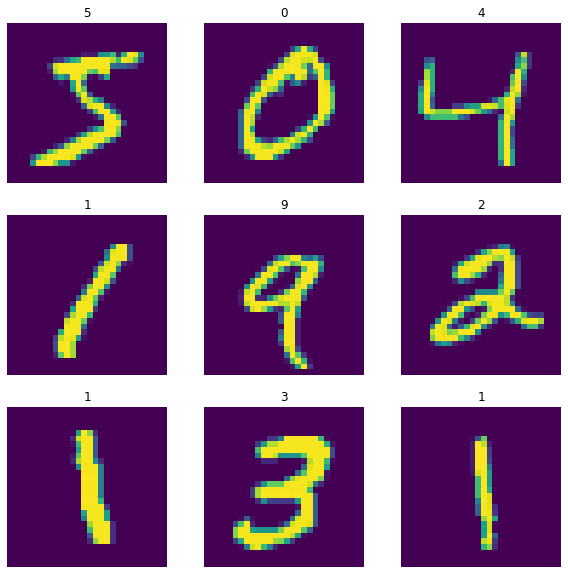

In [5]:
plt.figure(figsize=(10, 10))

for i, (image, label) in enumerate(zip(X_train, y_train)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")
    
    if i == 8:
        break

### Train ve test setlerinin birleştirilmesi

In [6]:
X, y = np.concatenate((X_train, X_test), axis=0), np.concatenate((y_train, y_test), axis=None)
X, y = shuffle(X, y, random_state=42)

### Train ve test setleri dağılımlarının görselleştirilmesi ve incelenmesi

In [7]:
def yuzde_hesapla(pct, X):
    adet = int(pct / 100*len(X))
    return "{:.2f}%\n{:d} resim".format(pct, adet)

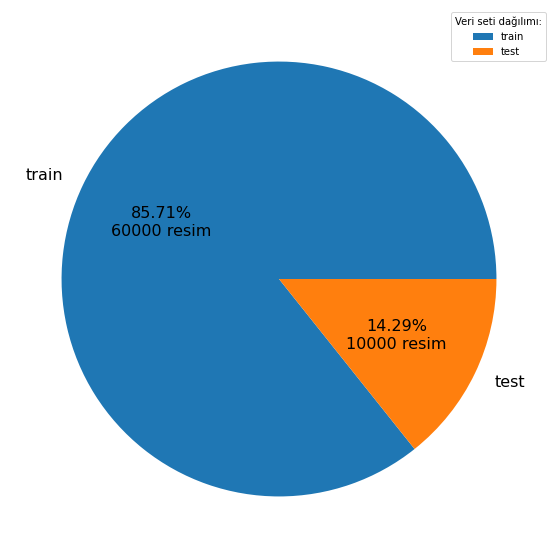

In [8]:
_lbl = ["train", "test"]
plt.figure(figsize=(10, 10))
plt.pie((len(X_train), len(X_test)), labels=_lbl, autopct=lambda pct: yuzde_hesapla(pct, X), textprops={'fontsize': 16})
plt.legend(title = "Veri seti dağılımı:")
plt.show()

#### Train veri setinin dağılımlarının görselleştirilmesi ve incelenmesi

In [9]:
ytrain_unique, ytrain_counts = np.unique(y_train, return_counts=True)
y_train_dist = dict(zip(ytrain_unique, ytrain_counts))

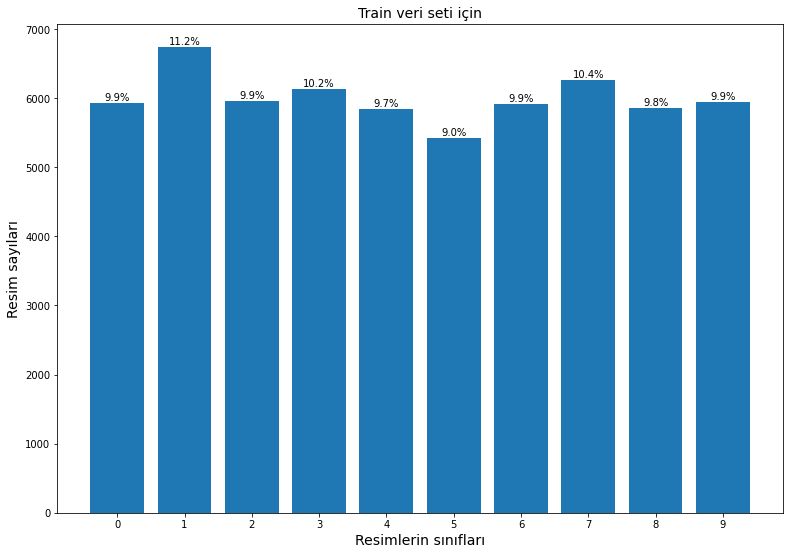

In [10]:
fig, ax = plt.subplots(figsize =(13, 9))
ax.bar(list(y_train_dist.keys()), list(y_train_dist.values()))

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(X_train):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
    
plt.title("Train veri seti için", size=14)
plt.xlabel("Resimlerin sınıfları", size=14)
plt.xticks(list(y_train_dist.keys()))
plt.ylabel("Resim sayıları", size=14)

plt.show()

#### Test veri setinin dağılımlarının görselleştirilmesi ve incelenmesi

In [11]:
ytest_unique, ytest_counts = np.unique(y_test, return_counts=True)
y_test_dist = dict(zip(ytest_unique, ytest_counts))

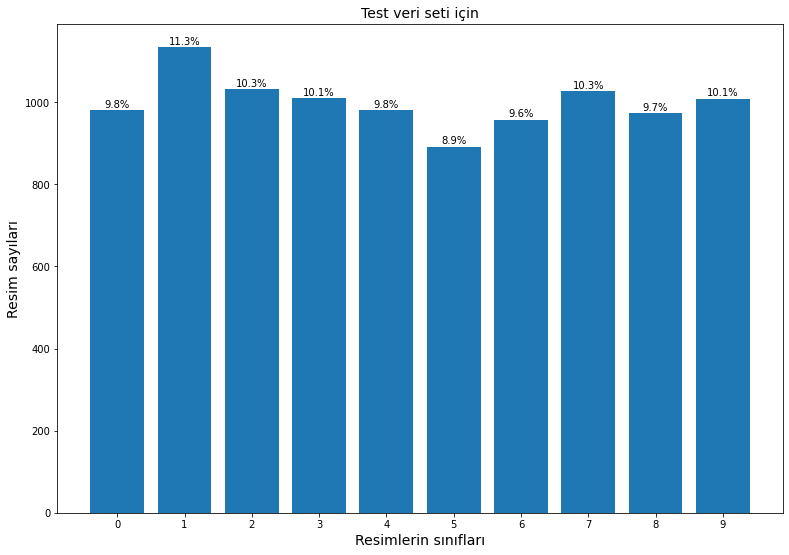

In [29]:
fig, ax = plt.subplots(figsize =(13, 9))
ax.bar(list(y_test_dist.keys()), list(y_test_dist.values()))

for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(X_test):.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
    
plt.title("Test veri seti için", size=14)
plt.xlabel("Resimlerin sınıfları", size=14)
plt.xticks(list(y_test_dist.keys()))
plt.ylabel("Resim sayıları", size=14)

plt.show()

## Veri setinin hazır hale getirilmesi

### Normalizasyon (MinMax Scaling) işleminin yapılması

In [13]:
X = X.astype("float32") / 255
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

### Train ve test setleri için flatten işleminin gerçekleştirilmesi

#### Resimler'in boyutu 28x28 olduğundan ötürü bu durumda resimlerin matrisinin boyutu (N, 28\*28*1) olacaktır.

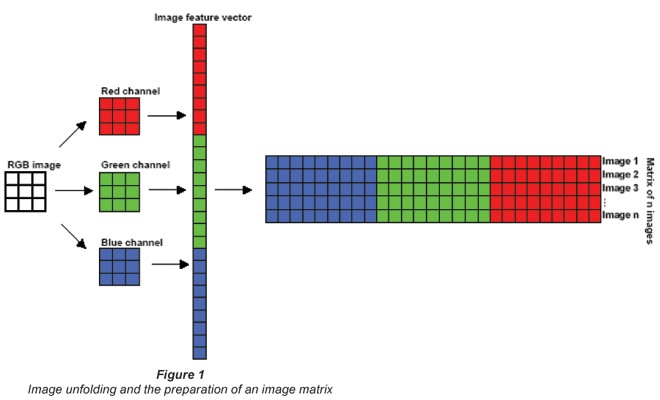

In [14]:
X = X.reshape(-1, height * width)
X_train = X_train.reshape(-1, width * height)
X_test = X_test.reshape(-1, width * height)

## İlk KNN modelinin oluşturulması

### KNN modelinin import edilmesi ve modelin oluşturulması

In [15]:
knn = KNeighborsClassifier(n_neighbors=10)
knn_fit = knn.fit(X_train, y_train)

### Modelin başarımının ölçülmesi

In [16]:
tic = time.time()
y_pred = knn_fit.predict(X_test)
toc = time.time()
cost_time = toc-tic
print("{:d} adet verinin tahmin edilmesi {:.1f} s sürdü.".format(len(X_test), cost_time))
acc = accuracy_score(y_test, y_pred)
print("Komşu sayısı {} için modelin doğruluk oranı: {}".format(knn.n_neighbors, round(acc, 3)))

10000 adet verinin tahmin edilmesi 71.8 s sürdü.
Komşu sayısı 10 için modelin doğruluk oranı: 0.966


#### Model başarımının daha detaylı incelenmesi

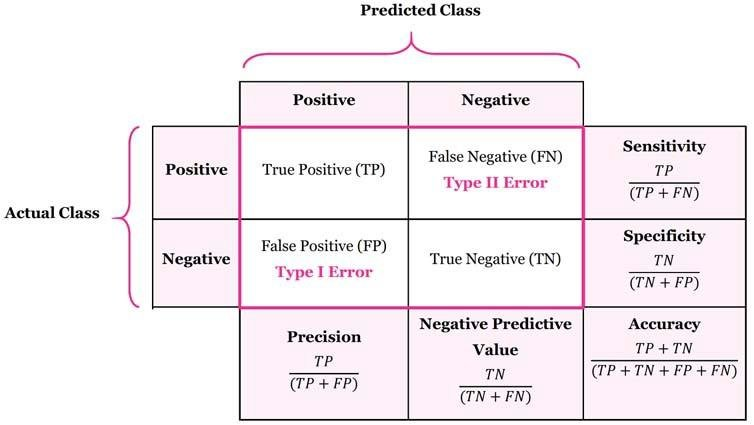

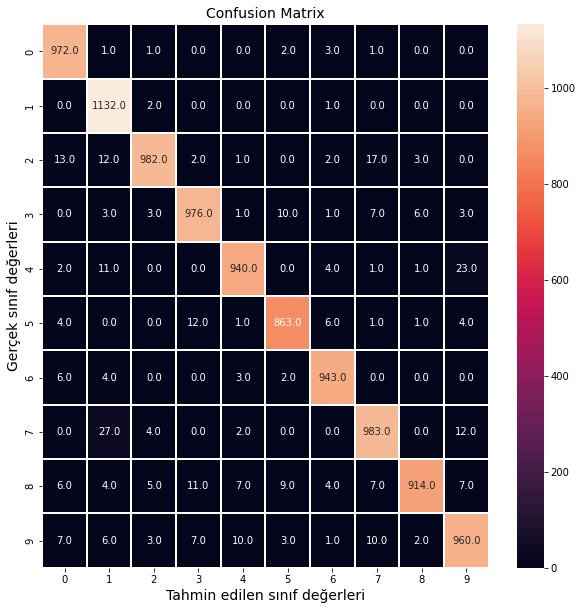

In [17]:
confusion_mtx = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt='.1f', ax=ax)
plt.xlabel('Tahmin edilen sınıf değerleri', size=14)
plt.ylabel('Gerçek sınıf değerleri', size=14)
plt.title('Confusion Matrix', size=14)
plt.show()

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.94      1.00      0.97      1135
           2       0.98      0.95      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## KNN modeli için tune işleminin gerçekleştirilmesi 
#### (En yüksek doğruluklu komşu sayısının belirlenmesi)

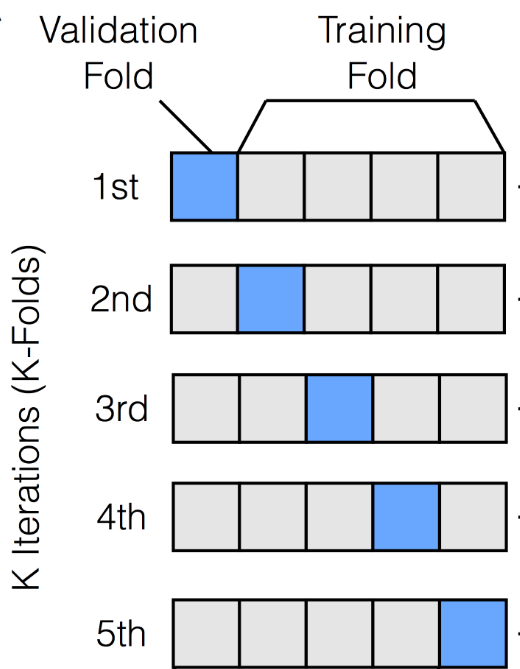

In [ ]:
knn = KNeighborsClassifier()
knn_params = {"n_neighbors": np.arange(1, 20)}
knn_cv_model = GridSearchCV(knn, knn_params, cv=5).fit(X, y)

In [1]:
print("En iyi knn score'u: {}".format(knn_cv_model.best_score_))
print("Knn için en iyi parametreleri: {}".format(knn_cv_model.best_params_))

En iyi knn score'u: 3
Knn için en iyi parametreleri: {'n_neighbors': 3}


### Tuned edilmiş KNN modelinin oluşturulması

In [19]:
knn_tuned = KNeighborsClassifier(n_neighbors=3)

In [20]:
knn_tuned.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)

## Model başarım değerlendirilmesi

### Tuned edilmiş modelin başarımının değerlendirilmesi

In [21]:
acc_tuned = accuracy_score(y_test, y_pred)
print("Komşu sayısı {} için modelin doğruluk oranı: {}".format(knn_tuned.n_neighbors, round(acc_tuned, 3)))

Komşu sayısı 3 için modelin doğruluk oranı: 0.97


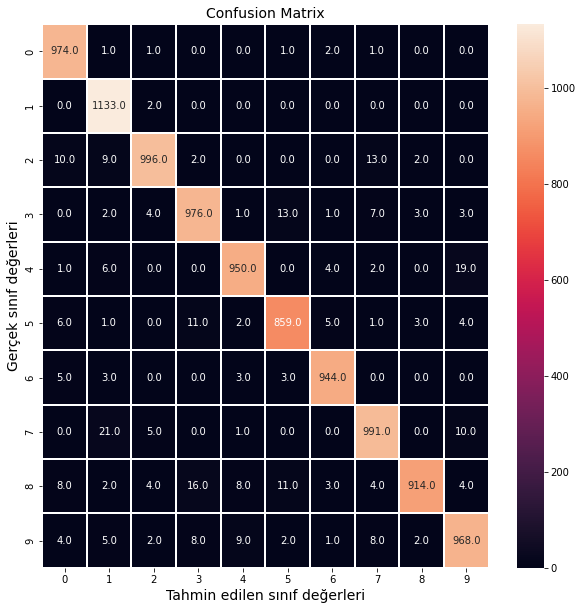

In [22]:
confusion_mtx = confusion_matrix(y_test, y_pred)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, fmt='.1f', ax=ax)
plt.xlabel('Tahmin edilen sınıf değerleri', size=14)
plt.ylabel('Gerçek sınıf değerleri', size=14)
plt.title('Confusion Matrix', size=14)
plt.show()

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### ROC Eğrisinin incelenmesi

#### Tüm sınıflar için ROC eğrisinin hesaplanması

In [24]:
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = list(y_train_dist.keys())
n_classes = len(y_train_dist.keys())

y_probs = knn_tuned.predict_proba(X_test)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

#### Micro ve Macro ROC eğrilerinin hesaplanması

In [25]:
y_test_bin = label_binarize(y_test, classes=classes)

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
avg_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    avg_tpr += np.interp(all_fpr, fpr[i], tpr[i])

avg_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = avg_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#### Tüm hesaplanan roc eğrilerinin görselleştirilmesi

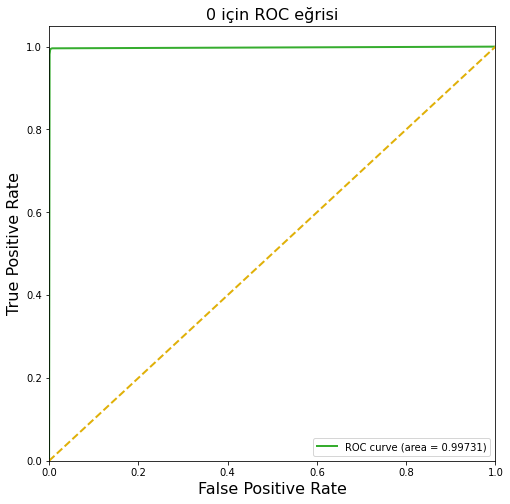

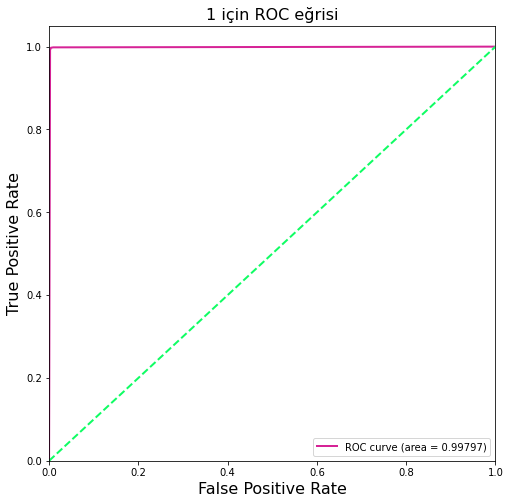

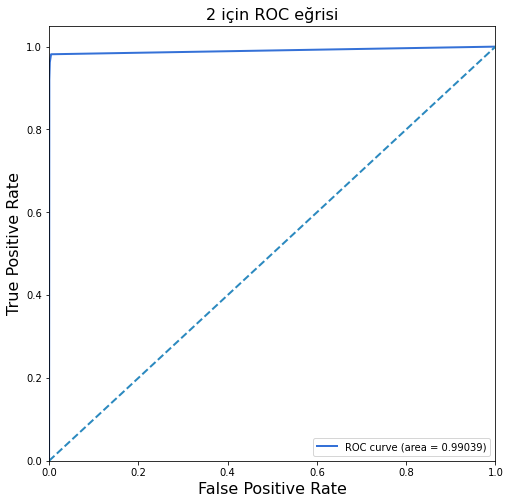

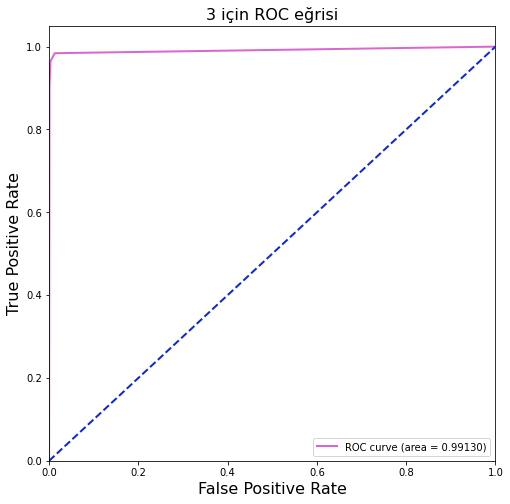

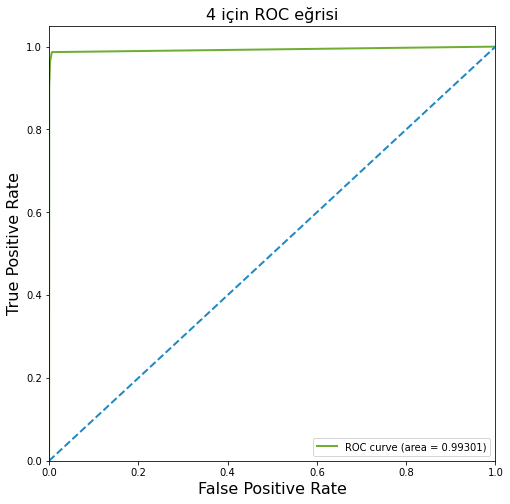

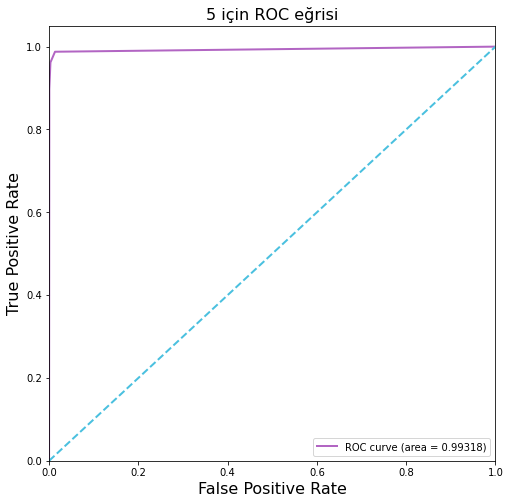

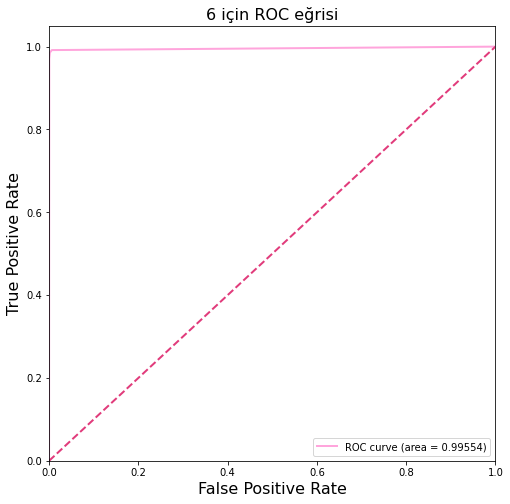

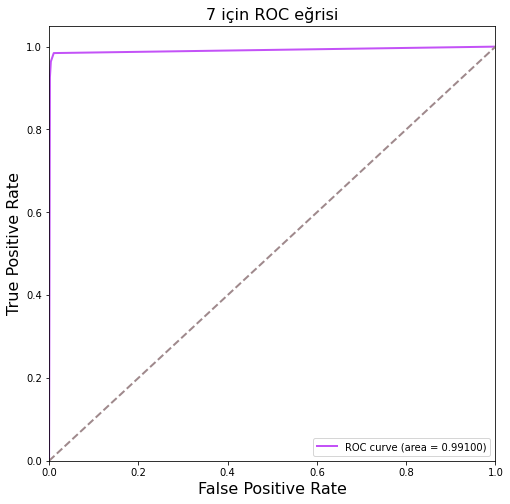

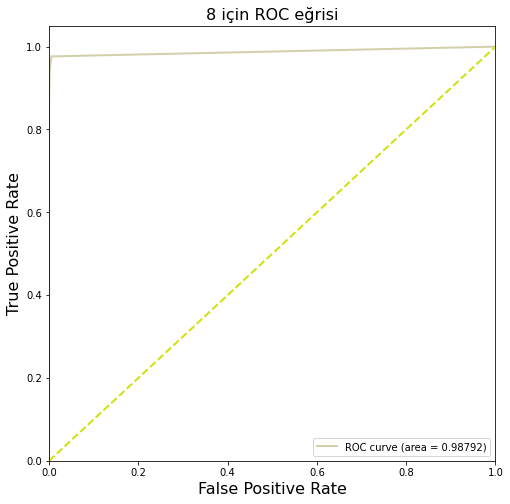

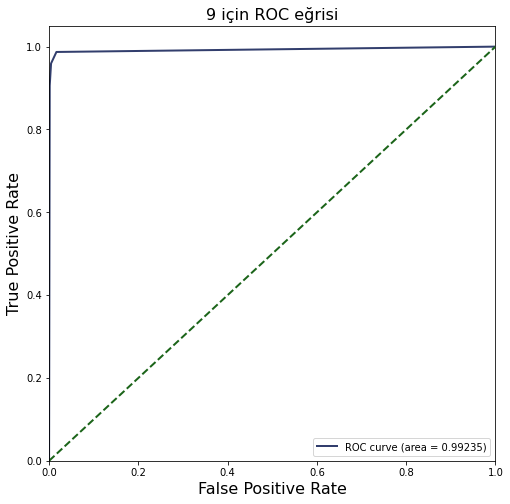

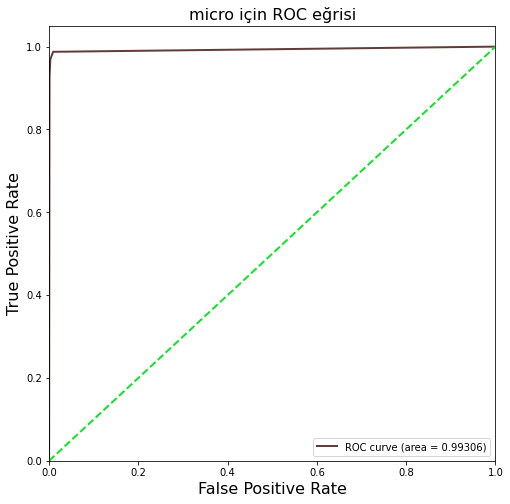

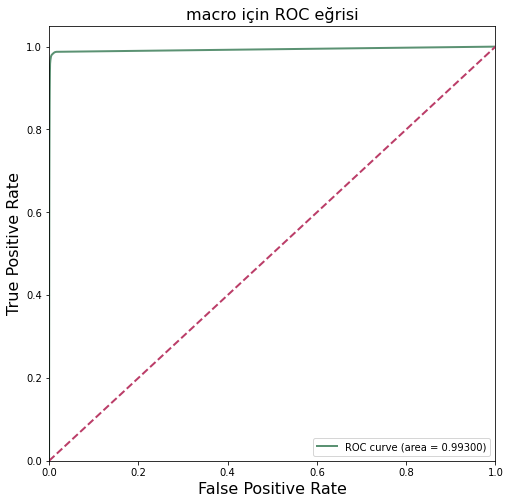

In [26]:
for key in roc_auc.keys():
    plt.figure(figsize=(8, 8))
    
    lw = 2
    roc_color = np.random.rand(3,)
    line_color = np.random.rand(3,)
    
    plt.plot(fpr[key], tpr[key], color=roc_color, lw=lw, label="ROC curve (area = %0.5f)" % roc_auc[key])
    plt.plot([0, 1], [0, 1], color=line_color, lw=lw, linestyle="--")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel("False Positive Rate", size=16)
    plt.ylabel("True Positive Rate", size=16)
    
    plt.title(f"{key} için ROC eğrisi", size=16)
    plt.legend(loc="lower right")
    plt.show()

## Optik Karakterlerin Okunması ve Test Edilmesi

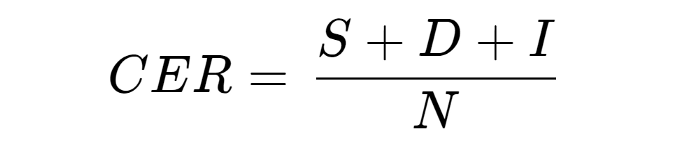

In [27]:
test_img = cv2.imread("test-image.png")
img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

_, img_th = cv2.threshold(img_blur, 90, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(contour) for contour in contours]

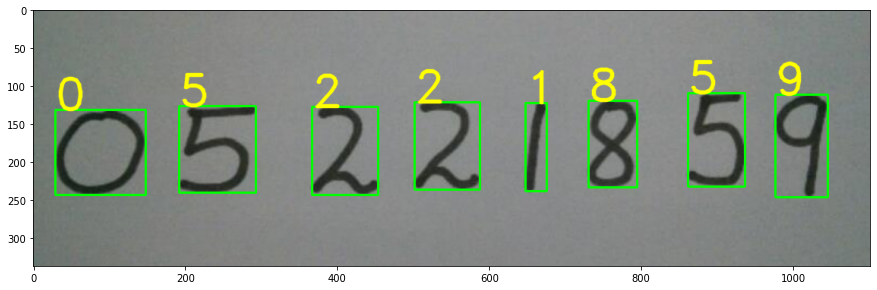

In [28]:
for rect in rects: 
    x, y, w, h = rect[0], rect[1], rect[2], rect[3]
    cv2.rectangle(test_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    leng = int(h * 1.5)
    pt1 = int(y + h // 2 - leng // 2)
    pt2 = int(x + w // 2 - leng // 2)
    
    th_roi = img_th[pt1: pt1 + leng, pt2: pt2 + leng]
    resize_roi = cv2.resize(th_roi, (height, width), interpolation=cv2.INTER_AREA)
    dilated_roi = cv2.dilate(resize_roi, (3, 3))
    
    float32_roi = dilated_roi.astype("float32") / 255
    flatten_roi = float32_roi.reshape(-1, height * width)

    assert flatten_roi.shape == (1, height * width), "Wrong Input shape" 
    assert flatten_roi.dtype == "float32", "Wrong Input dtype" 

    output = knn_tuned.predict(flatten_roi)
    cv2.putText(test_img, str(output[0]), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 2, cv2.LINE_AA)
    
rgb_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (15,15))
plt.imshow(rgb_img)